# CAB420, Metric Learning, Example 3: Triplet Loss
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
What's better than a pair of images? Three images! With this realisation, the triplet loss was born. 

The triplet loss really just extends the siamese networks by making them bigger. Now we have three streams, three images, and a loss that looks all of those together. Cricially, the triplet is made of two image from the same class, and one from a second, different, class. So when the network evalautes a triplet of images, it evaluates a positive pair, and a negative pair simultaenously.

This example is going to build fairly heavily on the CAB420_Metric_Learning_Example_2_Contrastive_Loss example.

## Too Long; Didn't Read:
* The triplet extends our earlier networks by adding a third stream. This however shares weights with the other streams much like we're used to.
* By using three images, we can form two pairs, a positive pair, which has images of the same type, an a negative pair, which has images of different types. The network aims to make the distance between the positive pair less than the negative pair by a specified margin.
* We can use normalisation again to help avoid the need to set a margin.
* By simultaenously using both a positive and negative pair, we can get better separation between similar and dissimliar pairs.

In [1]:
import random
import numpy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# for consistency
random.seed(4)

## The Data
As per this series, we're using fashion MNIST. 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

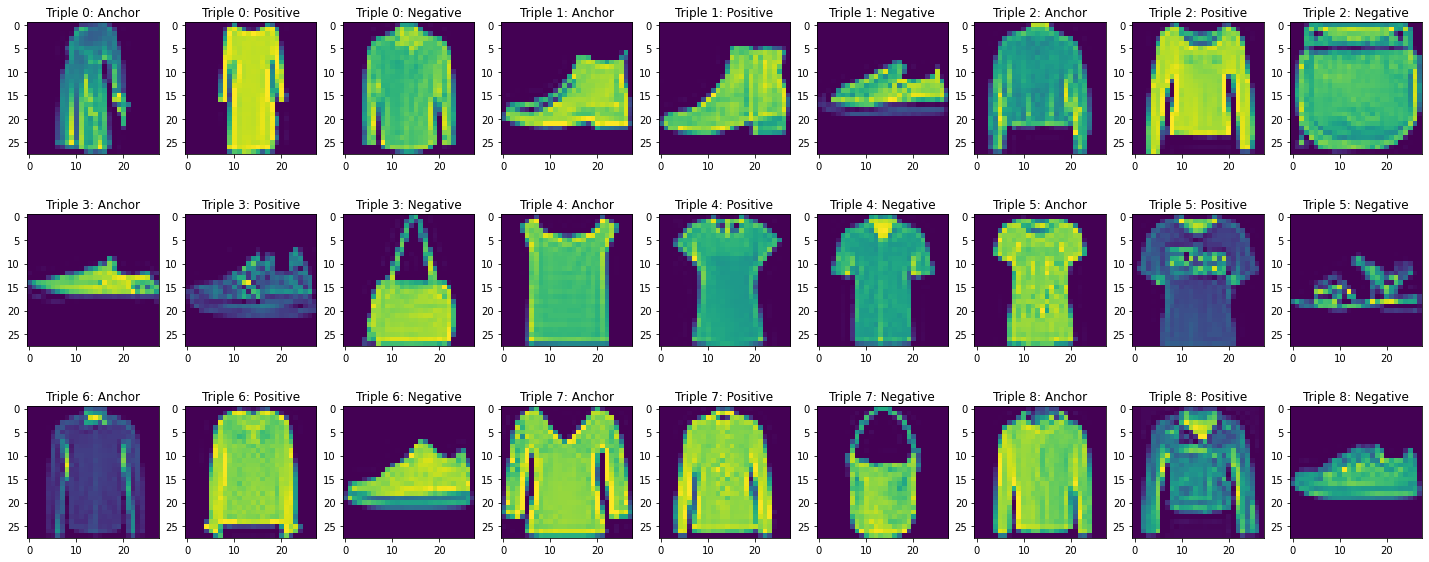

In [3]:
def GetSiameseData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label

def GetTripletData(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

def TripleGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b, image_c] = GetTripletData(imgs, labels, batch_size)
        yield [image_a, image_b, image_c], None

test = TripleGenerator(x_train, y_train, 9)
x, _ = next(test)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triple ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triple ' + str(i) + ': Negative')

## The Network
This should be looking familar by now. We'll run with the same network again.

In [4]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

Create the common branch here, as per last time:
* Create an input
* Create the network with our desired parameters
* Add an embedding layer
* Turn that into a model

In [5]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

### New Stuff
Again, something different here.

#### Triplet Loss Formulation

As per last time, we'll take moment to consider the maths. We now have three images, we're going to call then:
* $a$: the anchor
* $p$: the positive image, this is the same class as the anchor
* $n$: the negative image, this is a different class to the anchor

From these three images we can get two distances, using some distance function of our choosing:
* $d(a,p)$: which is the distance between the anchor and positive image. We want this to be small.
* $d(a,n)$: which is the distance between the anchor and negative image. We want this to be big.

From this, we get our triplet loss:

$L_{triplet} = max(d(a,p) - d(a,n) + margin, 0)$

If $d(a,p) - d(a,n) > margin$, then our loss will return $0$, otherwise it will return a positive value which indicates how far short of $margin$ the difference is. As with the contrastive loss, the aim of the network is to get embeddings of the same class close to one another, and embeddings from different classes far away; but now we can do this all at once as a single input to the network contains a positive and a negative pair.

#### Triplet Loss Implementation

Again, I'm borrowing. This time from [here](https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352), where there's a rather nice triplet loss layer implementation (incidently, there's some other interesting stuff in that post too that may be of interest).

Why use a layer for our loss and not just a function? Really it comes down to a practical choice, and it being easier to wrangle the three inputs (anchor, positive and negative) in a layer. Also, it's good to demonstrate custom layer creation.

In [6]:
class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [7]:
input_anchor = keras.Input((28, 28, 1), name='Anchor')
input_positive = keras.Input((28, 28, 1), name='Positive')
input_negative = keras.Input((28, 28, 1), name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

Note that we have a slightly weird setup here. Our loss is the layer, and we have no actual layers in our network (sort-of, the whole base network is there, it's just kind-of hidden). As the inputs are triplets and we simply seek to minimise a distance between the triplets, we don't need any labels - we just want to make the output of this as small as possible.

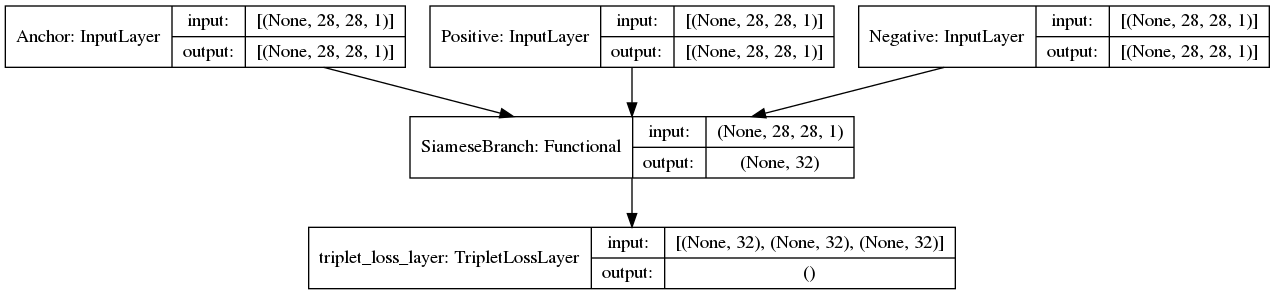

In [8]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
keras.utils.plot_model(triplet_network, show_shapes=True)

And now we can train our network, much like we have before.

In [9]:
triplet_network.compile(optimizer=keras.optimizers.Adam())

batch_size = 128
training_gen = TripleGenerator(x_train, y_train, batch_size)
triplet_test_x = GetTripletData(x_test, y_test, 10000)

triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_test_x, None))

Epoch 1/10
468/468 [==============================] - 10s 17ms/step - loss: 36.1041 - val_loss: 4.1881
Epoch 2/10
468/468 [==============================] - 7s 15ms/step - loss: 16.9149 - val_loss: 3.7174
Epoch 3/10
468/468 [==============================] - 6s 13ms/step - loss: 14.2385 - val_loss: 3.2489
Epoch 4/10
468/468 [==============================] - 7s 15ms/step - loss: 13.0522 - val_loss: 2.7932
Epoch 5/10
468/468 [==============================] - 7s 15ms/step - loss: 11.5614 - val_loss: 2.8207
Epoch 6/10
468/468 [==============================] - 6s 14ms/step - loss: 11.1857 - val_loss: 2.5750
Epoch 7/10
468/468 [==============================] - 7s 14ms/step - loss: 10.4486 - val_loss: 2.5122
Epoch 8/10
468/468 [==============================] - 7s 15ms/step - loss: 9.8202 - val_loss: 2.4062
Epoch 9/10
468/468 [==============================] - 6s 13ms/step - loss: 9.5620 - val_loss: 2.4635
Epoch 10/10
468/468 [==============================] - 7s 15ms/step - loss: 9.3039 

## The Results
Let's have a look at some outputs.

We'll start with just a random 10 samples and see what it returns. For extra info, we'll plot the raw score out of the network rather than the rounded result, and show the expected score in brackets.

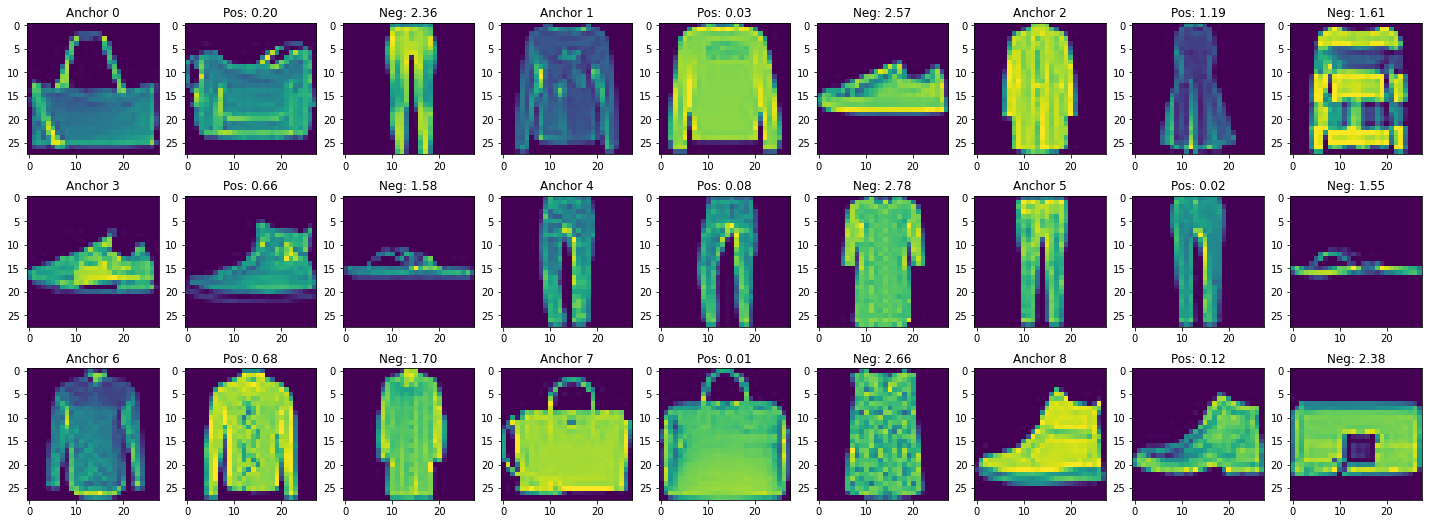

In [10]:
def ComputeDistance(x, y):
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    dist = K.sum(K.square(x - y), axis=-1)
    return dist

x = GetTripletData(x_test, y_test, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 9])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pos: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Neg: ' + '%1.2f' % float(neg_dists[i]))

This looks pretty good. In general, we've got a much bigger gap between our positive and negative examples.

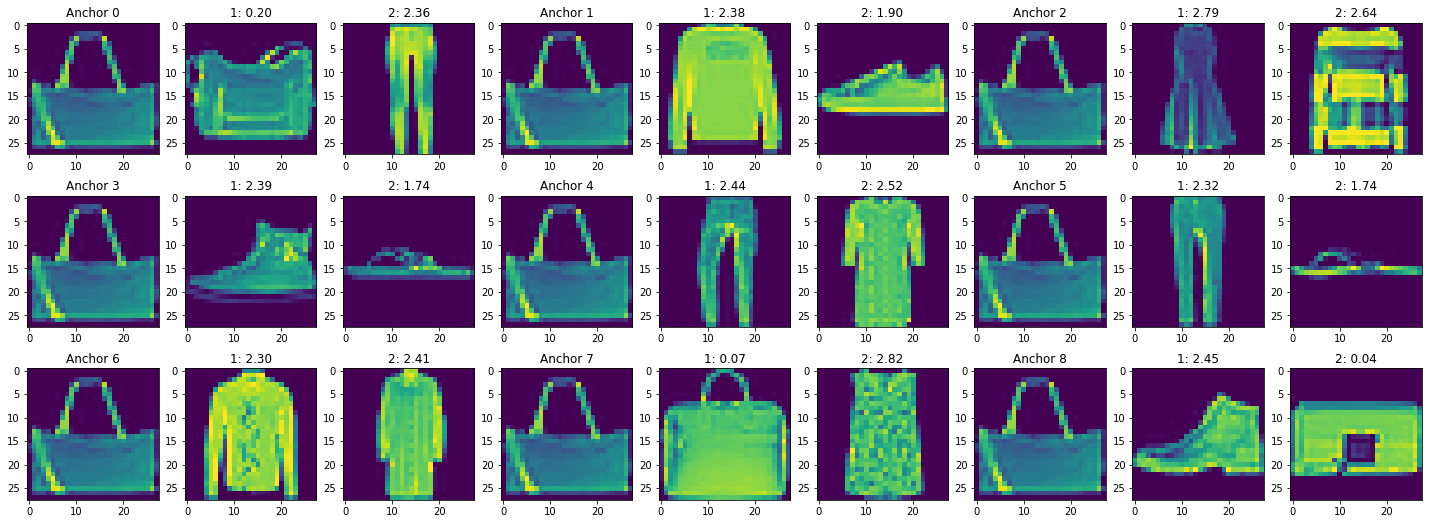

In [11]:
for i in range(9):
    x[0][i,:] = x[0][0,:]

anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 9])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('1: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('2: ' + '%1.2f' % float(neg_dists[i]))

Looking at the above examples is also promising, and the distributions below show better separation between the positive and negative cases. It's still not perfect (far from it), but on the whole heading in the right direction.

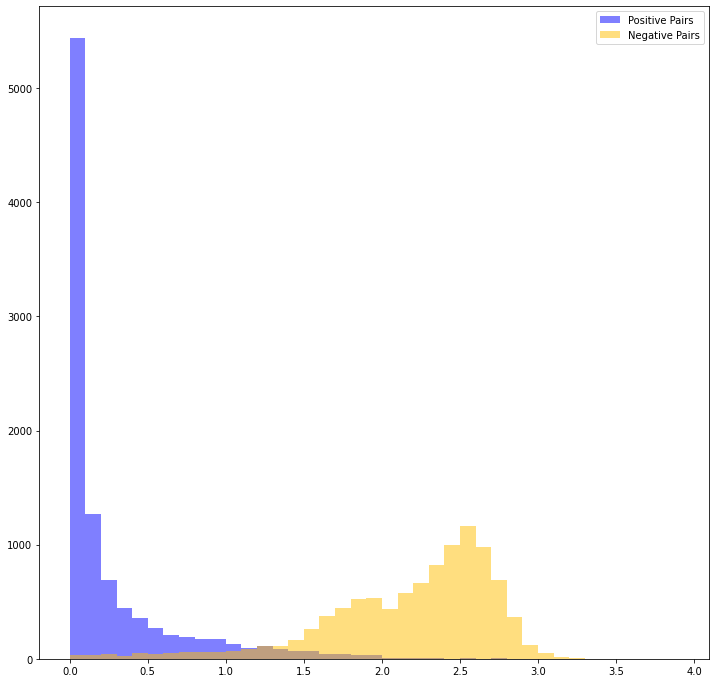

In [12]:
anchor_embedding = base_network.predict(triplet_test_x[0])
positive_embedding = base_network.predict(triplet_test_x[1])
negative_embedding = base_network.predict(triplet_test_x[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, numpy.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, numpy.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

Finally we come to the embeddings, and we see again that these look promising. The groups are perhaps not as compact as we'd like, and there is still some confusion between classes, but it's much better than the binary cross entropy loss and at least as good, if not better, than the contrastive loss case. 

As noted in the summary below, we also need to remember that:
* Our network is very simple
* Our embedding is very small
* We haven't trained the network for that long

Changing any (or all) of these would lead to better performance again.

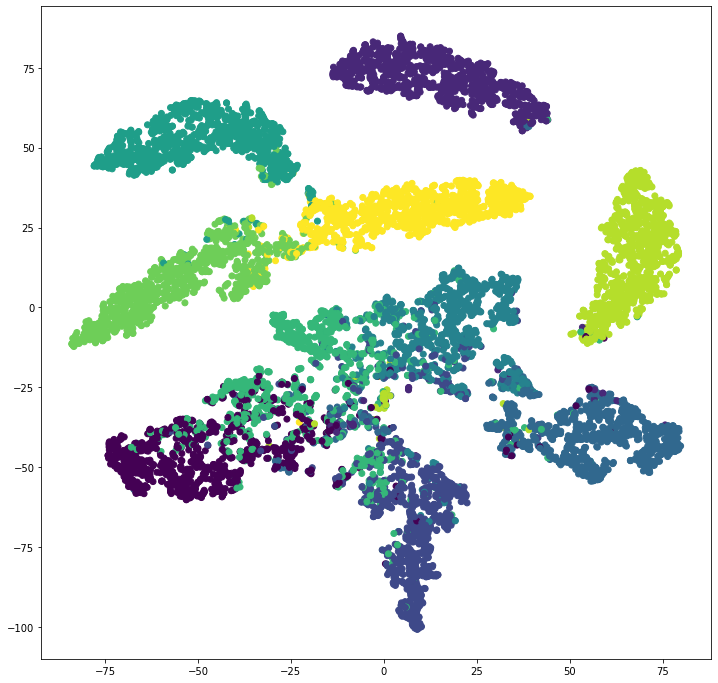

In [13]:
embeddings = base_network.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

## Final Thoughts

So what have we learnt today?

It's worth reflecting on the three formulations that we've considered for this task, where we've used
* Binary Cross Entropy (BCE) Loss;
* Contrastive Loss; and
* Triplet Loss.

With all of these we've used the same, simple network - yet got quite different results. All we've really changed is the loss function. It's very easy to get carried away with deep nets and keep adding layer after layer, making them more complex in the hope that they'll learn more or learn better. Often though, quite dramatic results can be achieved by tweaking the loss function. Consider out BCE loss, it only cared if two things were the same class. It could do that ok, but the embedding that it learned wasn't necessarily useful for other tasks, like ranking or grouping similar things. With the contrastive loss, we improved this somewhat, but our loss was most interested in making sure that different things were far enough away from each other. As such, the distances in general got pushed out.

The triplet loss was able to do a much better job. By having each example now contain a set of three images, containing a matching pair and a non-matching pair, each example was now able to guide the network to make the matching images closer together than the mismatching pair, while also attempting to force the mismatching pair to be further apart than some margin. This results in a much better end result, and while classes aren't perfectly separated, it's better than it was.

So, at this point it'a also fair to ask, how much further can (or should) this go? We could further and improve performance by:
* Adding another image to expose the network to more diverse negative pairs; i.e. get two negative distances per example through the network.
* Adding another margin to control the distance between the positive pairs; i.e. force positives images to be no further apart than some distance.

However, while both these will help performance, returns will also begin to diminish. We also at likely at the point where our underlying network is limiting performance. We have got a very simple VGG-like network sitting behind this, and we've also got quite a small embedding of size 32. Increasing one or both of these may also improve performance.

One other point worth mentioning is that different things can be done with both the distance metric and the embeddings themselves. For example we could switch to using another metric such as the cosine distance (i.e. the angle between the vectors/embeddings).

Finally, one point worth making is that we don't need to train these networks from scratch. We could just as easily pick a network thats been trained for an image classification type task, remove the layers we don't need, and fine tune from that. The vast majority of methods in the literature that use this sort of architecture do exactly that.